In [1]:
!pip install -U git+https://github.com/qubvel/segmentation_models.pytorch

  Cloning https://github.com/qubvel/segmentation_models.pytorch to /tmp/pip-req-build-48j84qrq
  Running command git clone -q https://github.com/qubvel/segmentation_models.pytorch /tmp/pip-req-build-48j84qrq
     |████████████████████████████████| 61kB 2.0MB/s 
  Created wheel for segmentation-models-pytorch: filename=segmentation_models_pytorch-0.1.0-cp36-none-any.whl size=43838 sha256=febbeb151cb18e0b5e68ea5befefd34072516d224152c1c91f6686aab5b4f327
  Stored in directory: /tmp/pip-ephem-wheel-cache-7860s_t2/wheels/79/3f/09/1587a252e0314d26ad242d6d2e165622ab95c95e5cfe4b942c
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-cp36-none-any.whl size=60963 sha256=860208a10914009d63cb3be794542cdc5252c5269f4cf19569f9a9166c3b7075
  Stored in directory: /tmp/.cache/pip/wheels/69/df/63/62583c096289713f22db605aa2334de5b591d59861a02c2ecd
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.5.1-cp36-none-any.whl size=11768 sha256=c66f991f6569725711132cc6d886

In [2]:
import os
import gc
import sys
import cv2
import pdb
import time
import math
from os.path import isfile

import random
import numpy as np
import pandas as pd


from tqdm import tqdm

import matplotlib.pyplot as plt


import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau


from albumentations import (HorizontalFlip, VerticalFlip, ShiftScaleRotate, Normalize, Resize, Compose, GaussNoise, RandomBrightnessContrast, RandomScale)
#from albumentations.torch import ToTensor
from albumentations.pytorch import ToTensorV2


import segmentation_models_pytorch as smp

import warnings
warnings.filterwarnings("ignore")



# kernel_start_time = time.time()

In [3]:
DATA_FOLDER = "../input/imaterialist-fashion-2019-FGVC6/"

TRAIN_IMGS = DATA_FOLDER+"train/"
TEST_IMGS = DATA_FOLDER+"test/"
TRAIN_CSV = DATA_FOLDER+"train.csv"
LABEL_DESCRIPTIONS = DATA_FOLDER+"label_descriptions.json"

# for simplicity, we'll keep target mask size and image resize shapes the same
IMG_HEIGHT = 512
IMG_WIDTH = 512

# ImageNet stats
NORM_MEAN = (0.485, 0.456, 0.406)
NORM_STD = (0.229, 0.224, 0.225)

NUM_CLASSES = 46+1 # 46 + BG class

# this is just a demonstration, so we'll take just a small sample of data
SAMPLE_SIZE = 10

BATCH_SIZE = 10
NUM_EPOCHS = 20

SEED = 42

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(SEED)

In [5]:
train_df = pd.read_csv(TRAIN_CSV)
train_df.head()

,ImageId,EncodedPixels,Height,Width,ClassId
0,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,6068157 7 6073371 20 6078584 34 6083797 48 608...,5214,3676,6
1,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,6323163 11 6328356 32 6333549 53 6338742 75 63...,5214,3676,0
2,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,8521389 10 8526585 30 8531789 42 8537002 46 85...,5214,3676,28
3,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,12903854 2 12909064 7 12914275 10 12919485 15 ...,5214,3676,31
4,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,10837337 5 10842542 14 10847746 24 10852951 33...,5214,3676,32


In [6]:
train_df['ImageId'].nunique() # num images in train

45195

In [7]:
test_images = os.listdir(TEST_IMGS)
len(test_images)

3193

In [8]:
# some labels contain attributes
len(train_df[train_df['ClassId'].str.contains('_')]) / len(train_df) # fraction of labels with attributes

0.034717840181393844

In [9]:
train_df['ClassId'].apply(lambda x: x.split('_')[0]).nunique() # only 46 main classes

46

In [10]:
train_df['ClassId'] = train_df['ClassId'].apply(lambda x: x.split('_')[0]).astype(int) # drop attributes info, consider only main class

In [11]:
train_df.head()

,ImageId,EncodedPixels,Height,Width,ClassId
0,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,6068157 7 6073371 20 6078584 34 6083797 48 608...,5214,3676,6
1,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,6323163 11 6328356 32 6333549 53 6338742 75 63...,5214,3676,0
2,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,8521389 10 8526585 30 8531789 42 8537002 46 85...,5214,3676,28
3,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,12903854 2 12909064 7 12914275 10 12919485 15 ...,5214,3676,31
4,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,10837337 5 10842542 14 10847746 24 10852951 33...,5214,3676,32


In [12]:
# transform to "one row - one image" format
df = train_df.groupby('ImageId')['EncodedPixels', 'ClassId'].agg(lambda x: list(x))
df = pd.merge(df, train_df[['ImageId','Height','Width']].groupby('ImageId').first(), on='ImageId')
df.head()

,EncodedPixels,ClassId,Height,Width
ImageId,,,,
00000663ed1ff0c4e0132b9b9ac53f6e.jpg,[6068157 7 6073371 20 6078584 34 6083797 48 60...,"[6, 0, 28, 31, 32, 32, 31, 29, 4]",5214,3676
0000fe7c9191fba733c8a69cfaf962b7.jpg,[2201176 1 2203623 3 2206071 5 2208518 8 22109...,"[33, 1]",2448,2448
0002ec21ddb8477e98b2cbb87ea2e269.jpg,[2673735 2 2676734 8 2679734 13 2682733 19 268...,"[33, 10, 23, 23]",3000,1997
0002f5a0ebc162ecfb73e2c91e3b8f62.jpg,[435 132 1002 132 1569 132 2136 132 2703 132 3...,"[10, 33, 15]",567,400
0004467156e47b0eb6de4aa6479cbd15.jpg,[132663 8 133396 25 134130 41 134868 53 135611...,"[10, 33, 31, 31, 15]",750,500


In [13]:
# function to decode RLE 
def mask2rle(img):
    '''
    img: numpy array, 1 -> mask, 0 -> background
    Returns run length as string formated
    '''
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

# function to return mask in format that can be used with CrossEntropyLoss
def make_mask_softmax(row_id, df, target_img_height, target_img_width):
    '''Given a row index, return image_id and mask (target_img_height, target_img_width) with pixel values
    being class label from [0,...,C] (0 - background) from dataframe `df`'''
    
    fname = df.iloc[row_id].name
    rles = df.iloc[row_id]['EncodedPixels']
    labels = df.iloc[row_id]['ClassId']
    img_height = df.iloc[row_id]['Height']
    img_width = df.iloc[row_id]['Width']
    
    # create zero flat mask
    mask = np.zeros(img_height * img_width, dtype=np.uint8)
    
    # fill pixels with labels
    for label, rle in zip(labels, rles):
        rle = rle.split(" ")
        positions = map(int, rle[0::2])
        length = map(int, rle[1::2])
        for pos, le in zip(positions, length):
            mask[pos:(pos + le)] = label+1
    
    # unflatten mask to (H, W)
    mask = mask.reshape(img_height, img_width, order='F')
    # resize mask to target size
    mask = cv2.resize(mask, (target_img_height, target_img_width), interpolation=cv2.INTER_AREA) 
    
    return fname, mask 


def get_and_resize_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH), interpolation=cv2.INTER_AREA)  
    return img

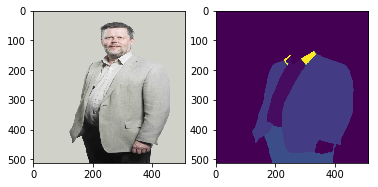

In [14]:
# checking
fname, mask = make_mask_softmax(0, df, IMG_HEIGHT, IMG_WIDTH)
img = get_and_resize_image(TRAIN_IMGS+fname)

# image and its mask
plt.subplot(1, 2, 1);
plt.imshow(img);
plt.subplot(1, 2, 2);
plt.imshow(mask);

In [15]:
# image transforms and augmentations
def get_transforms(phase, mean, std):
    list_transforms = []
    if phase == "train":
        list_transforms.extend(
            [
                HorizontalFlip(p=0.5), 
                RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.3),
            ]
        )
    list_transforms.extend(
        [
            Normalize(mean=mean, std=std, p=1),
            ToTensorV2(),
        ]
    )
    list_trfms = Compose(list_transforms)
    return list_trfms

In [16]:
class TrainDataset(Dataset):
    def __init__(self, df, img_dir, mean, std, phase, target_height, target_width):
        self.df = df
        self.img_dir = img_dir
        self.mean = mean
        self.std = std
        self.phase = phase
        self.target_height = target_height
        self.target_width = target_width
        self.transforms = get_transforms(phase, mean, std)
        self.fnames = self.df.index.tolist()

    def __getitem__(self, idx):
        image_id, mask = make_mask_softmax(idx, self.df, self.target_height, self.target_width)
        image_path = os.path.join(self.img_dir, image_id)
        img = get_and_resize_image(image_path)
        augmented = self.transforms(image=img, mask=mask)
        img = augmented['image']
        mask = augmented['mask'] 

        return img, mask.long()

    def __len__(self):
        return len(self.fnames)


In [17]:
def plot_history(scores, name, skip=0):
    plt.figure(figsize=(10,6))
    plt.plot(range(len(scores["train"][skip:])), scores["train"][skip:], label=f'Train {name}')
    plt.plot(range(len(scores["valid"][skip:])), scores["valid"][skip:], label=f'Valid {name}')
    plt.title(f'{name} plot'); plt.xlabel('Epoch'); plt.ylabel(f'{name}');
    plt.legend(); 
    plt.show()

In [18]:
train_data = TrainDataset(df.iloc[:SAMPLE_SIZE], TRAIN_IMGS, NORM_MEAN, NORM_STD, 'train', IMG_HEIGHT, IMG_WIDTH)
valid_data = TrainDataset(df.iloc[SAMPLE_SIZE:2*SAMPLE_SIZE], TRAIN_IMGS, NORM_MEAN, NORM_STD, 'valid', IMG_HEIGHT, IMG_WIDTH)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

## Model 1

In [19]:
model = smp.FPN(
    encoder_name='resnet34', 
    encoder_weights='imagenet', 
    classes=NUM_CLASSES, 
    activation=None,
)

loss = smp.utils.losses.CrossEntropyLoss()

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=[],
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=[],
    device=DEVICE,
    verbose=True,
)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /tmp/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 104MB/s] 



Epoch: 0
valid: 100%|██████████| 1/1 [00:01<00:00,  1.95s/it, cross_entropy_loss - 3.123]
Model saved!

Epoch: 1
valid: 100%|██████████| 1/1 [00:01<00:00,  1.95s/it, cross_entropy_loss - 1.941]
Model saved!

Epoch: 2
valid: 100%|██████████| 1/1 [00:01<00:00,  1.94s/it, cross_entropy_loss - 1.356]
Model saved!

Epoch: 3
valid: 100%|██████████| 1/1 [00:02<00:00,  2.05s/it, cross_entropy_loss - 1.128]
Model saved!

Epoch: 4
valid: 100%|██████████| 1/1 [00:02<00:00,  2.00s/it, cross_entropy_loss - 1.038]
Model saved!

Epoch: 5
valid: 100%|██████████| 1/1 [00:01<00:00,  1.90s/it, cross_entropy_loss - 0.9826]
Model saved!

Epoch: 6
valid: 100%|██████████| 1/1 [00:01<00:00,  1.91s/it, cross_entropy_loss - 0.9429]
Model saved!

Epoch: 7
valid: 100%|██████████| 1/1 [00:01<00:00,  1.94s/it, cross_entropy_loss - 0.9145]
Model saved!

Epoch: 8
valid: 100%|██████████| 1/1 [00:01<00:00,  1.91s/it, cross_entropy_loss - 0.8893]
Model saved!

Epoch: 9
valid: 100%|██████████| 1/1 [00:01<00:00,  1.90s/i

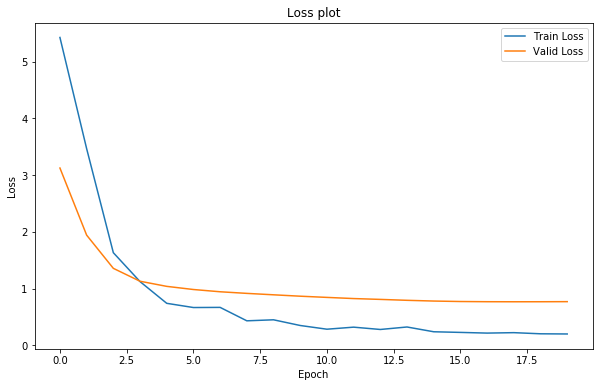

In [20]:
# train model for several epochs

min_loss = 1000
loss_history_train = []
loss_history_valid = []

for epoch in range(NUM_EPOCHS):
    
    print('\nEpoch: {}'.format(epoch))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    loss_history_train.append(train_logs['cross_entropy_loss'])
    loss_history_valid.append(valid_logs['cross_entropy_loss'])
    
    if min_loss > valid_logs['cross_entropy_loss']:
        min_loss = valid_logs['cross_entropy_loss']
        torch.save(model, './best_model.pth')
        print('Model saved!')
        
scores = dict()
scores['train'] = loss_history_train
scores['valid'] = loss_history_valid
plot_history(scores, 'Loss');

## Model 2

In [21]:
model = smp.Unet(
    encoder_name='resnet34', 
    encoder_weights='imagenet', 
    classes=NUM_CLASSES, 
    activation=None,
)

loss = smp.utils.losses.CrossEntropyLoss()

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=[],
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=[],
    device=DEVICE,
    verbose=True,
)


Epoch: 0
valid: 100%|██████████| 1/1 [00:02<00:00,  2.13s/it, cross_entropy_loss - 3.841]
Model saved!

Epoch: 1
valid: 100%|██████████| 1/1 [00:02<00:00,  2.15s/it, cross_entropy_loss - 3.847]

Epoch: 2
valid: 100%|██████████| 1/1 [00:02<00:00,  2.06s/it, cross_entropy_loss - 3.847]

Epoch: 3
valid: 100%|██████████| 1/1 [00:02<00:00,  2.16s/it, cross_entropy_loss - 3.838]
Model saved!

Epoch: 4
valid: 100%|██████████| 1/1 [00:02<00:00,  2.03s/it, cross_entropy_loss - 3.823]
Model saved!

Epoch: 5
valid: 100%|██████████| 1/1 [00:02<00:00,  2.19s/it, cross_entropy_loss - 3.807]
Model saved!

Epoch: 6
valid: 100%|██████████| 1/1 [00:02<00:00,  2.17s/it, cross_entropy_loss - 3.793]
Model saved!

Epoch: 7
valid: 100%|██████████| 1/1 [00:02<00:00,  2.19s/it, cross_entropy_loss - 3.778]
Model saved!

Epoch: 8
valid: 100%|██████████| 1/1 [00:02<00:00,  2.15s/it, cross_entropy_loss - 3.764]
Model saved!

Epoch: 9
valid: 100%|██████████| 1/1 [00:02<00:00,  2.27s/it, cross_entropy_loss - 3.749]

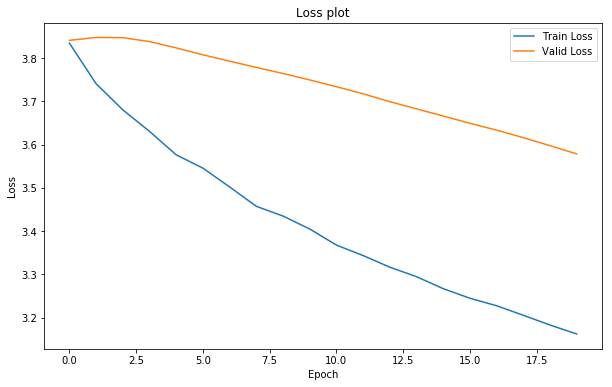

In [22]:
# train model for several epochs

min_loss = 1000
loss_history_train = []
loss_history_valid = []

for epoch in range(NUM_EPOCHS):
    
    print('\nEpoch: {}'.format(epoch))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    loss_history_train.append(train_logs['cross_entropy_loss'])
    loss_history_valid.append(valid_logs['cross_entropy_loss'])
    
    if min_loss > valid_logs['cross_entropy_loss']:
        min_loss = valid_logs['cross_entropy_loss']
        torch.save(model, './best_model.pth')
        print('Model saved!')
        
scores = dict()
scores['train'] = loss_history_train
scores['valid'] = loss_history_valid
plot_history(scores, 'Loss');

# Inference

In [23]:
def post_process(probability, threshold, min_size, img_height_target, img_width_target):
    '''Post processing of each predicted mask, components with lesser number of pixels
    than `min_size` are ignored'''
    mask = cv2.threshold(probability, threshold, 1, cv2.THRESH_BINARY)[1]
    num_component, component = cv2.connectedComponents(mask.astype(np.uint8))
    predictions = np.zeros((img_height_target, img_width_target), np.float32)
    num = 0
    for c in range(1, num_component):
        p = (component == c)
        if p.sum() > min_size:
            predictions[p] = 1
            num += 1
    return predictions, num

In [24]:
class TestDataset(Dataset):
    def __init__(self, data_dir, img_dir, mean, std, target_height, target_width):
        self.root = data_dir
        self.img_dir = img_dir
        self.mean = mean
        self.std = std
        self.target_height = target_height
        self.target_width = target_width
        self.transforms = get_transforms('test', mean, std)
        self.fnames = os.listdir(TEST_IMGS)[:SAMPLE_SIZE] # limit to only small fraction of the dataset

    def __getitem__(self, idx):
        image_id = self.fnames[idx]
        image_path = os.path.join(self.img_dir, image_id)
        img = get_and_resize_image(image_path)
        augmented = self.transforms(image=img)
        img = augmented['image']

        return image_id, img

    def __len__(self):
        return len(self.fnames)

In [25]:
test_data = TestDataset(DATA_FOLDER, TEST_IMGS, NORM_MEAN, NORM_STD, IMG_HEIGHT, IMG_WIDTH)

test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [26]:
predictions = []

model.eval()
with torch.no_grad():
    for i, batch in enumerate(tqdm(test_loader)):
        fnames, images = batch
        images = images.to(DEVICE)

        batch_preds = torch.softmax(model(images), axis=1)

        batch_preds = batch_preds.detach().cpu().numpy()
              
        for fname, preds in zip(fnames, batch_preds):
            for cls, pred in enumerate(preds):
                pred, num = post_process(pred, 0.01, 5000, IMG_HEIGHT, IMG_WIDTH)
                rle = mask2rle(pred)
                name = fname + f"_{cls}"
                predictions.append([name, rle])

100%|██████████| 1/1 [00:10<00:00, 10.10s/it]


In [27]:
df_preds = pd.DataFrame(predictions, columns=['Image_Label', 'EncodedPixels'])
df_preds.to_csv('preds.csv', index=False)
df_preds.head()

,Image_Label,EncodedPixels
0,4cacd353f49c86d43b4b616789776d3b.jpg_0,1 162484 162486 5570 168057 2573 170631 91514
1,4cacd353f49c86d43b4b616789776d3b.jpg_1,1 102354 102356 143736 246093 16052
2,4cacd353f49c86d43b4b616789776d3b.jpg_2,1 554 556 1495 2052 2 2059 97 2160 15 2176 2 2...
3,4cacd353f49c86d43b4b616789776d3b.jpg_3,1 18534 18537 1175 19713 3583 23297 370 23668 ...
4,4cacd353f49c86d43b4b616789776d3b.jpg_4,1 30878 30880 511 31394 509 31905 16443 48349 ...


In [ ]:
# There is one mistake in inference: classes got shifted by 1 (0 - background, 0 - 1, 1 - 2, ...)
# Just to not rerun the whole notebook